In [1]:
import cv2
import lzma
import pywt
import pickle
import matplotlib.pyplot as plt
from numpy.fft import *
from PIL import Image
from io import BytesIO

from util import *
%matplotlib inline

In [2]:
def rgb2ycrcb(im):
    return cv2.cvtColor(im[...,::-1], cv2.COLOR_BGR2YCR_CB)

def ycrcb2rgb(im):
    return cv2.cvtColor(im, cv2.COLOR_YCR_CB2BGR)[...,::-1]

def crop_center(img, scale):
    y, x = img.shape
    cropx = int(x * scale)
    cropy = int(y * scale)
    startx = x//2 - (cropx//2)
    starty = y//2 - (cropy//2)    
    return img[starty:starty+cropy, startx:startx+cropx]

def pad_zero(img, shape):
    y, x = shape
    cy, cx = img.shape
    output = np.zeros(shape, dtype=np.complex_)
    sx = x//2 - (cx//2)
    sy = y//2 - (cy//2)
    output[sy:sy+cy, sx:sx+cx] = img
    return output

def fftdownsample(im, factor):
    fourier = fftshift(fft2(im))
    fourier = crop_center(fourier, factor)
    fourier = ifftshift(fourier)
    output = ifft2(fourier)
    return output.real

def fftupsample(im, sz):
    fourier = fftshift(fft2(im))
    fourier = pad_zero(fourier, sz)
    fourier = ifftshift(fourier)
    output = ifft2(fourier)
    return output.real

def lossy_encode(stack, y_downscale, rb_downscale):
    h, w, _ = stack[0].shape
    ys, rs, bs = [], [], []
    py, pr, pb = 0., 0., 0.
    for im in stack:
        im = rgb2ycrcb(im).astype(np.float64)
        y = fftdownsample(im[...,0], y_downscale)
        r = fftdownsample(im[...,1], rb_downscale)
        b = fftdownsample(im[...,2], rb_downscale)
        ys.append(y - py)
        rs.append(r - pr)
        bs.append(b - pb)
        py, pr, pb = y, r, b
    return np.array(ys), np.array(rs), np.array(bs)

def lossy_decode(stack, sz):
    ims = []
    ys, rs, bs = stack
    py, pr, pb = 0., 0., 0.
    for y, r, b in zip(ys, rs, bs):
        y = fftupsample(y, sz)
        r = fftupsample(r, sz)
        b = fftupsample(b, sz)
        y, r, b = y+py, r+pr, b+pb
        py, pr, pb = y, r, b
        im = np.dstack([y, r, b])
        im = np.clip(im, 0, 255)
        im = ycrcb2rgb(im.astype(np.uint8))
        ims.append(im)
    return ims

def compress_array(arr):
    f = BytesIO()
    np.save(f, arr)
    arr_bytes = f.getvalue()
    f.close()
    return lzma.compress(arr_bytes)

def decomp_array(b):
    decomp = lzma.decompress(b)
    f = BytesIO(decomp)
    arr_rec = np.load(f)
    f.close()
    return arr_rec

# def compress_arrlist(arrlist):
#     f = BytesIO()
#     np.savez(f, arrlist)
#     arr_bytes = f.getvalue()
#     f.close()
#     return lzma.compress(arr_bytes)

# def decomp_arrlist(b):
#     decomp = lzma.decompress(b)
#     f = BytesIO(decomp)
#     arr_rec = np.load(f)
#     f.close()
#     return list(arr_rec)

In [8]:
stack = imageStack_load('Andy_Video.png')

IndexError: list index out of range

In [46]:
y_downscale = 0.3
rb_downscale = 0.1

h, w, _ = stack[0].shape
enc = lossy_encode(stack, y_downscale, rb_downscale)
ims = lossy_decode(enc, (h, w))

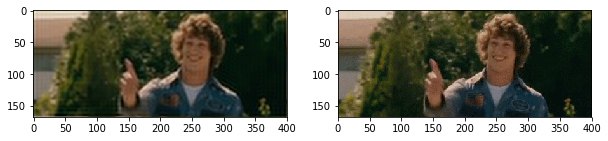

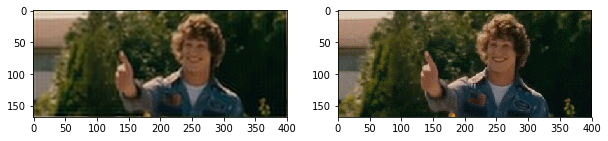

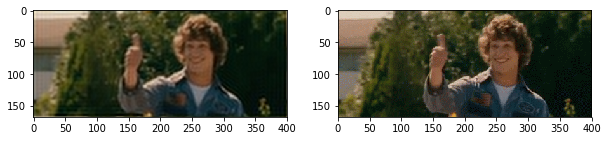

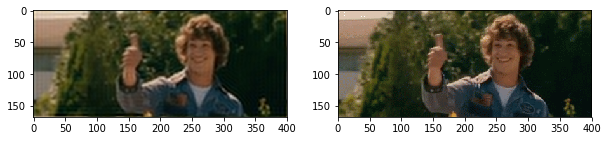

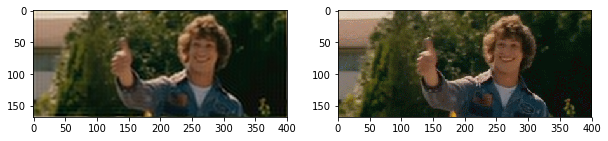

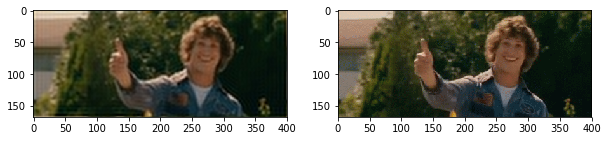

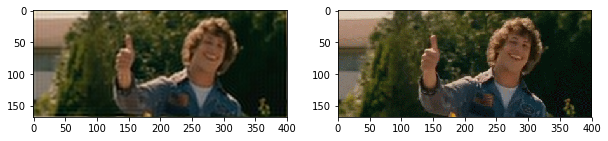

In [47]:
for i in range(len(ims)):
    plt.figure(figsize=(10, 8))
    plt.subplot(121)
    plt.imshow(ims[i])
    plt.subplot(122)
    plt.imshow(stack[i])
    plt.show()

In [51]:
ys, rs, bs = enc
l = 0
ll = 0
for y, r, b in zip(ys, rs, bs):
    z0, z1 = compress_array(y.astype(np.int16))
    l += len(z0)
    ll += len(z1)
    z0, z1 = compress_array(r.astype(np.int16))
    l += len(z0)
    ll += len(z1)
    z0, z1 = compress_array(b.astype(np.int16))
    l += len(z0)
    ll += len(z1)
print(l, ll)

64716 103600


In [52]:
l, ll = 0, 0
qys = [y.astype(np.int16) for y in ys]
qrs = [r.astype(np.int16) for r in rs]
qbs = [b.astype(np.int16) for b in bs]

z0, z1 = compress_arrlist(qys)
l += len(z0)
ll += len(z1)

z0, z1 = compress_arrlist(qrs)
l += len(z0)
ll += len(z1)

z0, z1 = compress_arrlist(qbs)
l += len(z0)
ll += len(z1)

print(l, ll)

58204 102508


In [60]:
qys = np.asarray(ys).astype(np.int16)
qrs = np.asarray(rs).astype(np.int16)
qbs = np.asarray(bs).astype(np.int16)

cys = compress_array(qys)
crs = compress_array(qrs)
cbs = compress_array(qbs)

dys = decomp_array(cys).astype(np.float64)
drs = decomp_array(crs).astype(np.float64)
dbs = decomp_array(cbs).astype(np.float64)

ims = lossy_decode([dys, drs, dbs], (h, w))

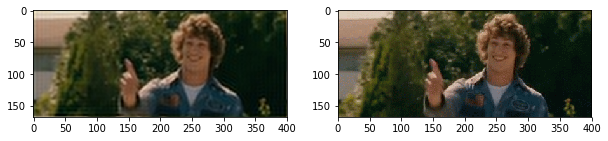

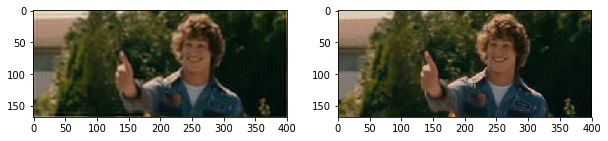

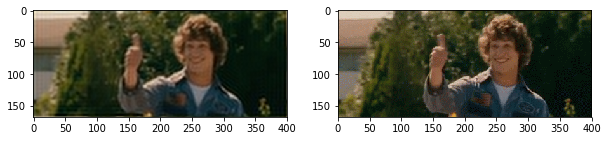

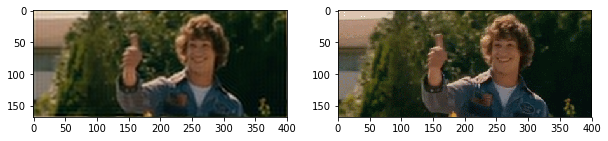

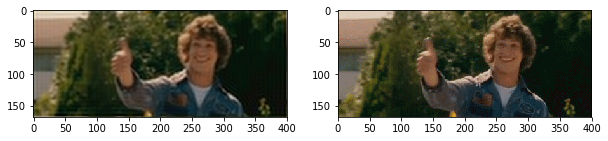

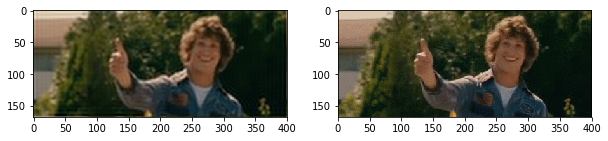

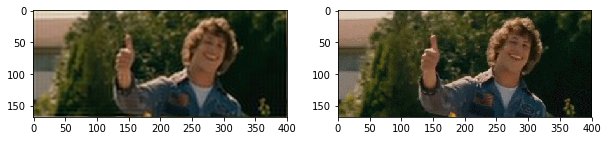

In [61]:
for i in range(len(ims)):
    plt.figure(figsize=(10, 8))
    plt.subplot(121)
    plt.imshow(ims[i])
    plt.subplot(122)
    plt.imshow(stack[i])
    plt.show()

In [62]:
Image.open('data/Andy_Video.png').info

{'aspect': (0, 1)}